## **Data Load**

In [1]:
# import all library
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time
import tracemalloc
from scipy.linalg import orth

In [2]:
mat_content = sio.loadmat('assets/face.mat')
# mat_content # Let's see the content...

face_data = mat_content['X']
face_labels = mat_content['l']

x_train, x_test, y_train, y_test = [], [], [], []

n_classes = 52
images_per_class = 10

for i in range(n_classes):
    start_idx = i * images_per_class
    end_idx = start_idx + images_per_class

    x_train.append(face_data[:, start_idx:start_idx+8])
    x_test.append(face_data[:, start_idx+8:end_idx])

    y_train.append(face_labels[:, start_idx:start_idx+8])
    y_test.append(face_labels[:, start_idx+8:end_idx])

x_train, x_test = np.hstack(x_train), np.hstack(x_test)
y_train, y_test = np.hstack(y_train), np.hstack(y_test)

x_train = x_train.astype(np.int64)
x_test = x_test.astype(np.int64)

# Output the shapes of the training and testing sets
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (2576, 416)
Test set shape: (2576, 104)


## **Q2. Incremental PCA**

creating subdatasets

In [3]:
x_sub1, x_sub2, x_sub3, x_sub4 = [], [], [], []
y_sub1, y_sub2, y_sub3, y_sub4 = [], [], [], []

n_classes = 52
images_per_class = 8

for i in range(n_classes):
  x_sub1.append(x_train[:,i*images_per_class :i*images_per_class + 2])
  x_sub2.append(x_train[:,i*images_per_class+2 :i*images_per_class + 4])
  x_sub3.append(x_train[:,i*images_per_class+4 :i*images_per_class + 6])
  x_sub4.append(x_train[:,i*images_per_class+6 :i*images_per_class + 8])

  y_sub1.append(y_train[:,i*images_per_class :i*images_per_class + 2])
  y_sub2.append(y_train[:,i*images_per_class+2 :i*images_per_class + 4])
  y_sub3.append(y_train[:,i*images_per_class+4 :i*images_per_class + 6])
  y_sub4.append(y_train[:,i*images_per_class+6 :i*images_per_class + 8])

x_sub1, x_sub2, x_sub3, x_sub4 = np.hstack(x_sub1), np.hstack(x_sub2), np.hstack(x_sub3), np.hstack(x_sub4)
y_sub1, y_sub2, y_sub3, y_sub4 = np.hstack(y_sub1), np.hstack(y_sub2), np.hstack(y_sub3), np.hstack(y_sub4)

x_subs = [x_sub1, x_sub2, x_sub3, x_sub4]
y_subs = [y_sub1, y_sub2, y_sub3, y_sub4]

Eigenvecs 직접 구한 버전

In [4]:
def get_mean_cov_mat(x_train):
    x_train_bar = np.average(x_train, axis=1).reshape(-1,1)
    A = x_train - x_train_bar
    S = np.matmul(A, A.T) / A.shape[1]
    return x_train_bar, S

In [5]:
def get_sorted_egivecs(n_components, eigvals, eigvecs):
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]
    eigvecs_n_comp = eigvecs[:, :n_components]

    return eigvecs_n_comp

In [6]:
def inc_pca(n_components, x_sub1, x_sub2, x_sub3, x_sub4, y_train, x_test, y_test):
    x_bar1, S_1 = get_mean_cov_mat(x_sub1)
    x_bar2, S_2 = get_mean_cov_mat(x_sub2)
    x_bar3, S_3 = get_mean_cov_mat(x_sub3)
    x_bar4, S_4 = get_mean_cov_mat(x_sub4)

    # only measure eigen-decomposition
    tracemalloc.start()
    start_time = time.perf_counter()
    # Get eigenvectors from each sub dataset
    eigvals1, eigvecs1 = np.linalg.eigh(S_1)
    eigvals2, eigvecs2 = np.linalg.eigh(S_2)
    eigvals3, eigvecs3 = np.linalg.eigh(S_3)
    eigvals4, eigvecs4 = np.linalg.eigh(S_4)

    run_time = time.perf_counter() - start_time
    _, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    P1 = get_sorted_egivecs(n_components, eigvals1, eigvecs1)
    P2 = get_sorted_egivecs(n_components, eigvals2, eigvecs2)
    P3 = get_sorted_egivecs(n_components, eigvals3, eigvecs3)
    P4 = get_sorted_egivecs(n_components, eigvals4, eigvecs4)


    # Incremental PCA -> merge
    combined_matrix = np.hstack((P1, P2))
    Phi = orth(combined_matrix) 
    P_new = Phi[:, :n_components]

    combined_matrix = np.hstack((P_new, P3))
    Phi = orth(combined_matrix) 
    P_new = Phi[:, :n_components]

    combined_matrix = np.hstack((P_new, P4))
    Phi = orth(combined_matrix) 
    P_new = Phi[:, :n_components]

    # mean update
    # x_bar = (x_bar1 + x_bar2 + x_bar3 + x_bar4) / 4
    x_bar = np.average(x_train, axis=1).reshape(-1,1)

    # Get reconstruction Error
    A_test = x_test - x_bar
    W_test = np.matmul(P_new.T, A_test)
    x_test_rec = x_bar + np.matmul(P_new, W_test)
    rec_err = np.mean(np.abs(x_test - x_test_rec))
    print(f"Reconstruction Error with eigenvectors (MAE): {rec_err:.2f}")

    # Get accuracy
    nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')

    x_train_proj = np.matmul(P_new.T, x_train - x_bar)
    x_test_proj = np.matmul(P_new.T, x_test - x_bar)

    nn.fit(x_train_proj.T, y_train.reshape(-1))

    y_pred = nn.predict(x_test_proj.T)
    accuracy = accuracy_score(y_test.T, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    
    return run_time, peak_memory
    
run_time, peak_memory = inc_pca(25, x_sub1, x_sub2, x_sub3, x_sub4, y_train, x_test, y_test)

print(f"Peak memory usage: {peak_memory / 10**6} MB")
print(f"Execution Time: {run_time:.8f} seconds")

Reconstruction Error with eigenvectors (MAE): 15.01
Accuracy: 59.62%
Peak memory usage: 212.430322 MB
Execution Time: 4.13985479 seconds


In [7]:
def pca(n_components, x_train, y_train, x_test, y_test):
    x_bar, S = get_mean_cov_mat(x_train)

    # only measure eigen-decomposition
    tracemalloc.start()
    start_time = time.perf_counter()
    # Get eigenvectors from each sub dataset
    eigvals, eigvecs = np.linalg.eigh(S)

    run_time = time.perf_counter() - start_time
    _, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    P = get_sorted_egivecs(n_components, eigvals, eigvecs)

    # Get reconstruction Error
    A_test = x_test - x_bar
    W_test = np.matmul(P.T, A_test)
    x_test_rec = x_bar + np.matmul(P, W_test)
    rec_err = np.mean(np.abs(x_test - x_test_rec))
    print(f"Reconstruction Error with eigenvectors (MAE): {rec_err:.2f}")

    # Get accuracy
    nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')

    x_train_proj = np.matmul(P.T, x_train - x_bar)
    x_test_proj = np.matmul(P.T, x_test - x_bar)

    nn.fit(x_train_proj.T, y_train.reshape(-1))

    y_pred = nn.predict(x_test_proj.T)
    accuracy = accuracy_score(y_test.T, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    return run_time, peak_memory
    

run_time, peak_memory = pca(30, x_train, y_train, x_test, y_test)

print(f"Peak memory usage: {peak_memory / 10**6} MB")
print(f"Execution Time: {run_time:.8f} seconds")


Reconstruction Error with eigenvectors (MAE): 13.47
Accuracy: 63.46%
Peak memory usage: 53.107994 MB
Execution Time: 1.19338225 seconds


Check Incremental PCA for large datasize

In [8]:
import numpy as np
from sklearn.decomposition import PCA, IncrementalPCA
import time
import matplotlib.pyplot as plt

# Parameters
data_sizes = [10000, 20000, 30000, 40000, 50000, 100000]
n_features = 50
n_components = 10
batch_size = 10000

runtime_batch_pca = []
runtime_incremental_pca = []
peak_memory_batch = []
peak_memory_ipca = []

for size in data_sizes:
    data = np.random.rand(size, n_features)
    
    # Measure runtime for Batch PCA
    tracemalloc.start()
    start_time = time.process_time()
    
    pca = PCA(n_components=n_components)
    pca.fit(data)

    current_memory, peak_memory = tracemalloc.get_traced_memory()
    runtime_batch_pca.append(time.process_time() - start_time)
    tracemalloc.stop()
    peak_memory_batch.append(peak_memory/(1024**2))
    
    tracemalloc.start()
    start_time = time.process_time()
    inc_pca = IncrementalPCA(n_components=n_components)
    for start in range(0, size, batch_size):
        end = min(start + batch_size, size)
        inc_pca.partial_fit(data[start:end])
    runtime_incremental_pca.append(time.process_time() - start_time)
    current_memory, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    peak_memory_ipca.append(peak_memory/(1024**2))

    print(f"Data Size: {size}, Batch PCA Time: {runtime_batch_pca[-1]:.2f} sec, Incremental PCA Time: {runtime_incremental_pca[-1]:.2f} sec")


Data Size: 10000, Batch PCA Time: 0.18 sec, Incremental PCA Time: 0.12 sec
Data Size: 20000, Batch PCA Time: 0.37 sec, Incremental PCA Time: 0.25 sec
Data Size: 30000, Batch PCA Time: 0.48 sec, Incremental PCA Time: 0.33 sec
Data Size: 40000, Batch PCA Time: 0.59 sec, Incremental PCA Time: 0.47 sec
Data Size: 50000, Batch PCA Time: 0.82 sec, Incremental PCA Time: 0.60 sec
Data Size: 100000, Batch PCA Time: 1.31 sec, Incremental PCA Time: 1.12 sec


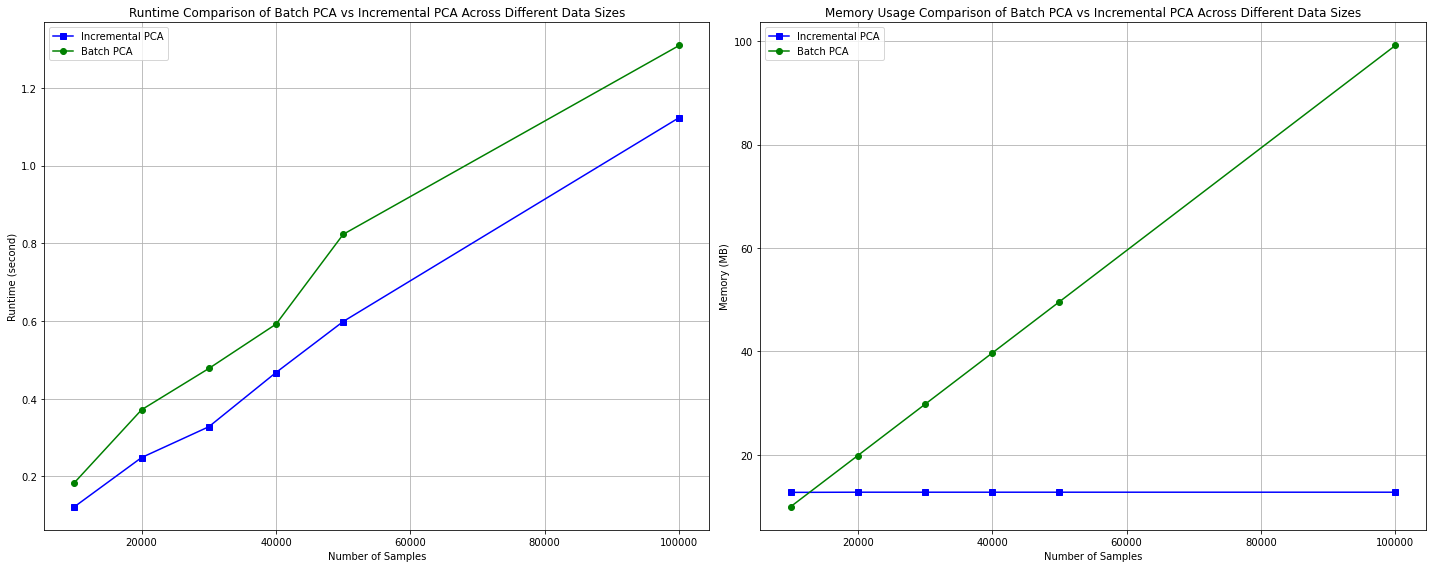

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].plot(data_sizes, runtime_incremental_pca, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[0].plot(data_sizes, runtime_batch_pca, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[0].set_xlabel('Number of Samples')
axes[0].set_ylabel('Runtime (second)')
axes[0].set_title("Runtime Comparison of Batch PCA vs Incremental PCA Across Different Data Sizes")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(data_sizes, peak_memory_ipca, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[1].plot(data_sizes, peak_memory_batch, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[1].set_xlabel('Number of Samples')
axes[1].set_ylabel('Memory (MB)')
axes[1].set_title("Memory Usage Comparison of Batch PCA vs Incremental PCA Across Different Data Sizes")
axes[1].legend()
axes[1].grid(True)

# Display the combined plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

Method in the lecture -> finding rotation matrix

In [15]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.linalg import orth

# Step 1: Perform PCA on the original and new data separately
pca1 = PCA(n_components=30)
pca2 = PCA(n_components=30)
pca3 = PCA(n_components=30)
pca4 = PCA(n_components=30)

P1 = pca1.fit(x_sub1.T).components_.T
P2 = pca2.fit(x_sub2.T).components_.T
P3 = pca3.fit(x_sub3.T).components_.T
P4 = pca4.fit(x_sub4.T).components_.T

# Step 1: Stack P1 and P2 column-wise to form the combined matrix
combined_matrix = np.hstack((P1, P2))
Phi = orth(combined_matrix) 
overlap_matrix = np.dot(P1.T, Phi)
U, _, Vt = np.linalg.svd(overlap_matrix)
min_dim = min(U.shape[1], Vt.shape[0])
U = U[:, :min_dim]
Vt = Vt[:min_dim, :]
R = np.dot(U, Vt)
P_new = np.dot(Phi, R.T)

combined_matrix = np.hstack((P_new, P3))
Phi = orth(combined_matrix) 
overlap_matrix = np.dot(P_new.T, Phi)
U, _, Vt = np.linalg.svd(overlap_matrix)
min_dim = min(U.shape[1], Vt.shape[0])
U = U[:, :min_dim]
Vt = Vt[:min_dim, :]
R = np.dot(U, Vt)
P_new = np.dot(Phi, R.T)

combined_matrix = np.hstack((P_new, P4))
Phi = orth(combined_matrix) 
overlap_matrix = np.dot(P_new.T, Phi)
U, _, Vt = np.linalg.svd(overlap_matrix)
min_dim = min(U.shape[1], Vt.shape[0])
U = U[:, :min_dim]
Vt = Vt[:min_dim, :]
R = np.dot(U, Vt)
P_new = np.dot(Phi, R.T)

P_new.shape


(2576, 30)

In [16]:
x_train_bar = np.average(x_train, axis=1).reshape(-1,1)

A_test = x_test - x_train_bar
W_test = np.matmul(P_new.T, A_test)
x_test_rec = x_train_bar + np.matmul(P_new, W_test)

rec_err = np.mean(np.abs(x_test - x_test_rec))
print(f"Reconstruction Error with eigenvectors (MAE): {rec_err}")

Reconstruction Error with eigenvectors (MAE): 16.73587031259519


In [17]:
# Define the 1-Nearest Neighbor classifier with L1 distance (Manhattan distance)
nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')

# projection of training images
x_train_proj = np.matmul(P_new.T, x_train - x_train_bar)
x_test_proj = np.matmul(P_new.T, x_test - x_train_bar)

nn.fit(x_train_proj.T, y_train.reshape(-1))

# Model prediction
y_pred = nn.predict(x_test_proj.T)


# Calculate Accuracy
accuracy = accuracy_score(y_test.T, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 64.42%
